In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from itertools import cycle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [5]:
# Load the dataset
df = pd.read_csv('requirment.csv', encoding='latin1')

In [7]:
print(df.head())

  Profile_Name         Rating_Star  \
0       John D  1.0 out of 5 stars   
1    Vickie G.  1.0 out of 5 stars   
2  tiggermommy  1.0 out of 5 stars   
3   J Q Public  1.0 out of 5 stars   
4        NanaB  5.0 out of 5 stars   

                                            Headings  \
0                       Steep price for a print app!   
1                                False advertising ?   
2                                   Do Not Download.   
3  Don't know how it works 'cause I couldn't prin...   
4                                         Five Stars   

                                        Base_Reviews         category  \
0  Downloaded this on a Kindle Fire 8 HD.  No ind...          feature   
1  It's free to download the app, but if you want...          feature   
2  I download this app to my Kindle Fire HD. I tr...            issue   
3  Dirty trickster! It found my printer and print...            issue   
4                Love this for my kindle print needs  user_experience

In [9]:
# Preprocessing the text data
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Define a function to clean the text
def clean_text(text):
    # Check if the input is a string, if not return as is
    if not isinstance(text, str):
        return text
    
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text

# Apply the clean_text function to the text column
X_clean = df['Base_Reviews'].apply(clean_text)

In [10]:
# Split the dataset into X and y
X = df['Base_Reviews'].values
y = df['category'].values

print(X)

['Downloaded this on a Kindle Fire 8 HD.  No indication it was a "pay only app".  No Free trial...  It installed no problem, setup to my printer was easy, but then I tried to print a 1 page document, it said I needed to install and pay for the premium version.  UNINSTALLED.  Got a different FREE app that works.  I don\'t want to pay $9.95 for something I might use maybe once a month or less...'
 "It's free to download the app, but if you want to actually use it, you need to upgrade to premium for $4.99. It's not free. I installed it, ran the setup wizard, gave it access to the printer and my files to find out I have to upgrade at a cost, to actually use it.  I am uninstalling frim my Kindle Fire as soon as I finish posting this review."
 'I download this app to my Kindle Fire HD. I tried to print and it would not let me print unless I upgraded to paying for the app.'
 ... 'Terrible....' "It's ok like every other"
 'I can not play I have to pick a picture from my gallery']


In [13]:


y_dict = {'feature': 0, 'user_experience': 1, 'issue': 2, 'other_information': 3}
y = [y_dict[item] for item in y]


In [15]:
# Convert the labels to categorical variables
num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)

In [17]:
# Tokenize the data
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [19]:
# Pad the sequences
maxlen = 100
X = pad_sequences(X, maxlen=maxlen)

In [21]:
# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)


# LSTM Model

In [24]:
#Define the LSTM model
lstm_model = keras.models.Sequential()
lstm_model.add(keras.layers.Embedding(max_features, 128, input_length=maxlen))
lstm_model.add(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(keras.layers.Dense(64, activation='relu'))
lstm_model.add(keras.layers.Dense(num_classes, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
lstm_model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          256000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 396100 (1.51 MB)
Trainable params: 396100 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# BiLSTM Model

In [26]:
# Define the BiLSTM model
bilstm_model = keras.models.Sequential()
bilstm_model.add(keras.layers.Embedding(max_features, 128, input_length=maxlen))
bilstm_model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(keras.layers.Dense(64, activation='relu'))
bilstm_model.add(keras.layers.Dense(num_classes, activation='softmax'))
bilstm_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          256000    
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 535876 (2.04 MB)
Trainable params: 535876 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# Perform k-fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

lstm_acc_scores = []
bilstm_acc_scores = []

In [30]:
for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

In [32]:
# Train the LSTM model on the current fold
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
lstm_acc_scores.append(lstm_acc)


                        

In [34]:
# Train the BiLSTM model on the current fold
bilstm_history = bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test, y_test, verbose=0)
bilstm_acc_scores.append(bilstm_acc)

# Calculate the average accuracy scores across the k-fold cross-validation
avg_lstm_acc = np.mean(lstm_acc_scores)
avg_bilstm_acc = np.mean(bilstm_acc_scores)



In [36]:
print("LSTM: Average Accuracy = {:.2f}".format(avg_lstm_acc))
print("BiLSTM: Average Accuracy = {:.2f}".format(avg_bilstm_acc))

# Confusion Matrix
lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)

lstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), lstm_pred)
bilstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), bilstm_pred)




LSTM: Average Accuracy = 0.94
BiLSTM: Average Accuracy = 0.94
105/105 [==============================] - 2s 18ms/step


In [38]:
# Confusion Matrix Visualization
#plt.figure(figsize=(8, 6))
#sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
#plt.title('LSTM Confusion Matrix')
#plt.xlabel('Predicted Class')
#plt.ylabel('True Class')
#plt.show()



In [40]:
#plt.figure(figsize=(8, 6))
#sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
#plt.title('BiLSTM Confusion Matrix')
#plt.xlabel('Predicted Class')
#plt.ylabel('True Class')
#plt.show()

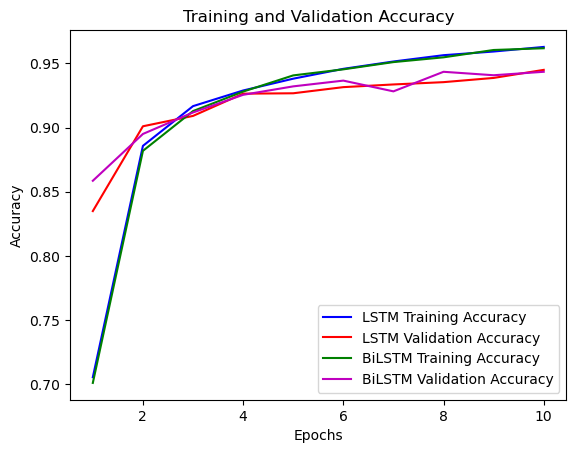

In [42]:
# Accuracy Graph
epochs = range(1, len(lstm_history.history['accuracy']) + 1)

plt.plot(epochs, lstm_history.history['accuracy'], 'b', label='LSTM Training Accuracy')
plt.plot(epochs, lstm_history.history['val_accuracy'], 'r', label='LSTM Validation Accuracy')
plt.plot(epochs, bilstm_history.history['accuracy'], 'g', label='BiLSTM Training Accuracy')
plt.plot(epochs, bilstm_history.history['val_accuracy'], 'm', label='BiLSTM Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


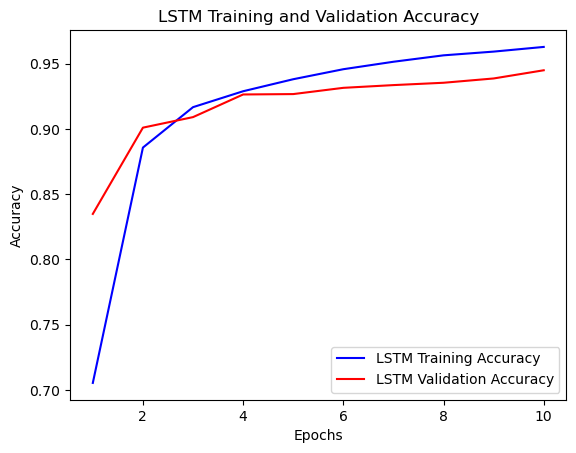

In [44]:
# LSTM Accuracy Graph
epochs = range(1, len(lstm_history.history['accuracy']) + 1)

plt.plot(epochs, lstm_history.history['accuracy'], 'b', label='LSTM Training Accuracy')
plt.plot(epochs, lstm_history.history['val_accuracy'], 'r', label='LSTM Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


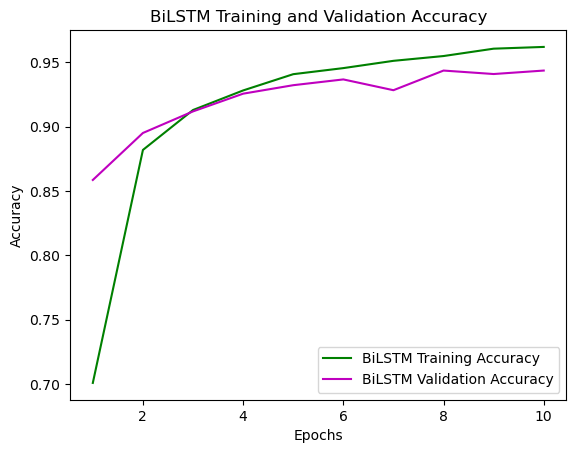

In [46]:
# BiLSTM Accuracy Graph
epochs = range(1, len(bilstm_history.history['accuracy']) + 1)

plt.plot(epochs, bilstm_history.history['accuracy'], 'g', label='BiLSTM Training Accuracy')
plt.plot(epochs, bilstm_history.history['val_accuracy'], 'm', label='BiLSTM Validation Accuracy')
plt.title('BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [48]:

# Calculate precision, recall, and F1-score for LSTM
lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
lstm_report = classification_report(np.argmax(y_test, axis=-1), lstm_pred)
print("LSTM Classification Report:")
print(lstm_report)




105/105 [==============================] - 1s 11ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       803
           1       0.98      0.81      0.88       810
           2       0.90      0.98      0.93       843
           3       0.95      0.99      0.97       887

    accuracy                           0.94      3343
   macro avg       0.95      0.94      0.94      3343
weighted avg       0.95      0.94      0.94      3343



In [50]:
# Calculate precision, recall, and F1-score for BiLSTM
bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)
bilstm_report = classification_report(np.argmax(y_test, axis=-1), bilstm_pred)
print("BiLSTM Classification Report:")
print(bilstm_report)
                       

105/105 [==============================] - 2s 16ms/step
BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       803
           1       0.94      0.83      0.88       810
           2       0.91      0.95      0.93       843
           3       0.96      0.99      0.97       887

    accuracy                           0.94      3343
   macro avg       0.94      0.94      0.94      3343
weighted avg       0.94      0.94      0.94      3343



In [52]:
   
    # Train the LSTM model on the current fold
    lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
    lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
    lstm_acc_scores.append(lstm_acc)
    

In [54]:
    
    # Train the BiLSTM model on the current fold
    bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
    bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test, y_test, verbose=0)
    bilstm_acc_scores.append(bilstm_acc)

In [56]:
# for train_index, test_index in kf.split(X_resampled):
#     X_train, X_test = X_resampled[train_index], X_resampled[test_index]
#     y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
#     # Train the LSTM model on the current fold
#     lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
#     lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
#     lstm_acc_scores.append(lstm_acc)
    
#     # Train the BiLSTM model on the current fold
#     bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
#     bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test, y_test, verbose=0)
#     bilstm_acc_scores.append(bilstm_acc)

In [58]:
# Calculate the average accuracy scores across the k-fold cross-validation
avg_lstm_acc = np.mean(lstm_acc_scores)
avg_bilstm_acc = np.mean(bilstm_acc_scores)

In [60]:
print("LSTM: Average Accuracy = {:.2f}".format(avg_lstm_acc))
print("BiLSTM: Average Accuracy = {:.2f}".format(avg_bilstm_acc))


LSTM: Average Accuracy = 0.95
BiLSTM: Average Accuracy = 0.95


In [62]:
# Confusion Matrix
lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)

lstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), lstm_pred)
bilstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), bilstm_pred)


105/105 [==============================] - 2s 15ms/step


In [64]:
# Confusion Matrix Visualization
#plt.figure(figsize=(8, 6))
#sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
#plt.title('LSTM Confusion Matrix')
#plt.xlabel('Predicted Class')
#plt.ylabel('True Class')
#plt.show()

#plt.figure(figsize=(8, 6))
#sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
#plt.title('BiLSTM Confusion Matrix')
#plt.xlabel('Predicted Class')
#plt.ylabel('True Class')
#plt.show()

In [66]:
# Calculate the ROC curve and AUC for each class
n_classes = y_test.shape[1]

# For LSTM model
lstm_y_score = lstm_model.predict(X_test)
lstm_fpr = dict()
lstm_tpr = dict()
lstm_roc_auc = dict()

# For BiLSTM model
bilstm_y_score = bilstm_model.predict(X_test)
bilstm_fpr = dict()
bilstm_tpr = dict()
bilstm_roc_auc = dict()

for i in range(n_classes):
    lstm_fpr[i], lstm_tpr[i], _ = roc_curve(y_test[:, i], lstm_y_score[:, i])
    lstm_roc_auc[i] = auc(lstm_fpr[i], lstm_tpr[i])
    
    bilstm_fpr[i], bilstm_tpr[i], _ = roc_curve(y_test[:, i], bilstm_y_score[:, i])
    bilstm_roc_auc[i] = auc(bilstm_fpr[i], bilstm_tpr[i])



105/105 [==============================] - 2s 18ms/step


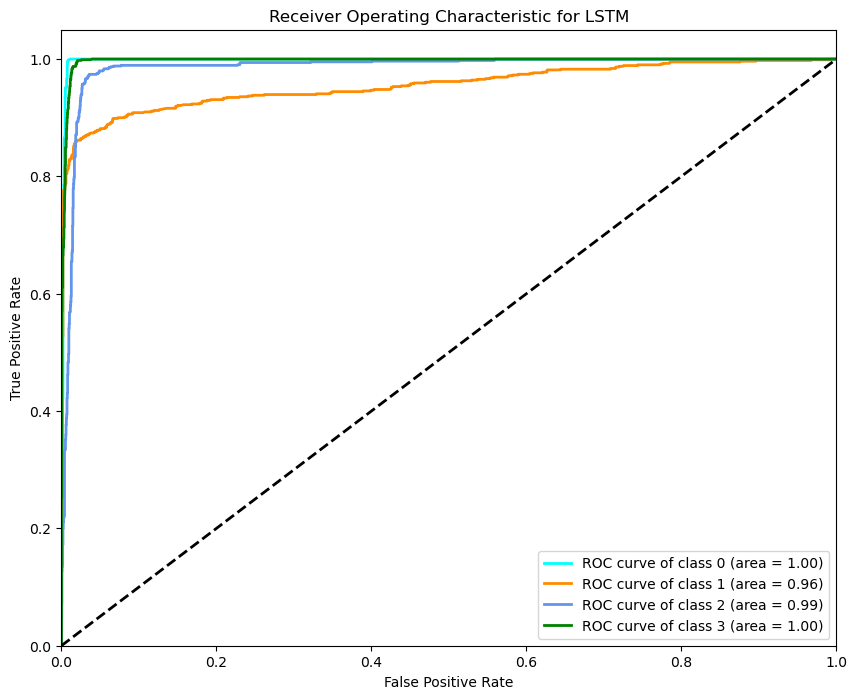

In [68]:
# Plot the ROC curve for LSTM model
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(lstm_fpr[i], lstm_tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, lstm_roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LSTM')
plt.legend(loc="lower right")
plt.show()



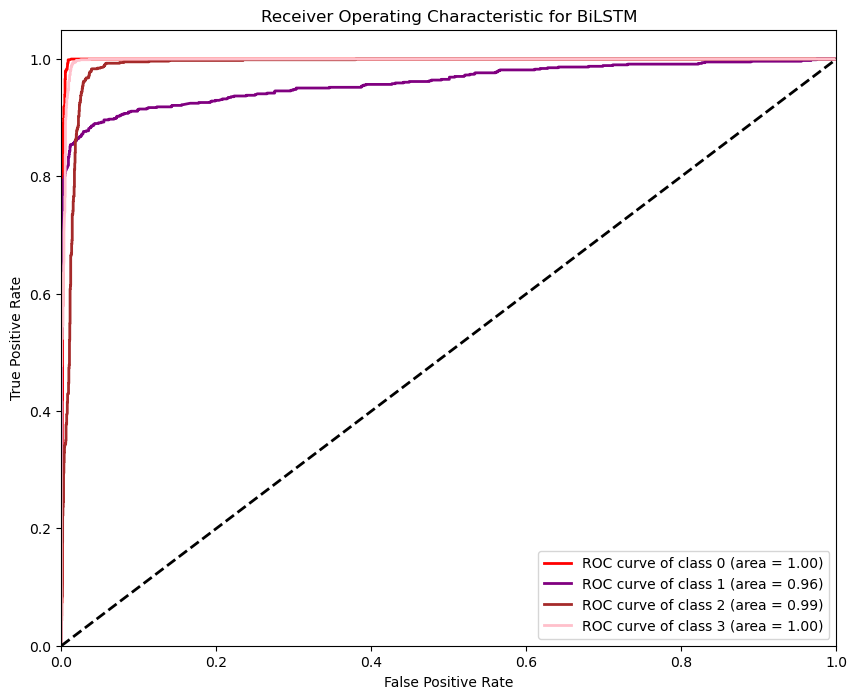

In [70]:
# Plot the ROC curve for BiLSTM model
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(bilstm_fpr[i], bilstm_tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, bilstm_roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for BiLSTM')
plt.legend(loc="lower right")
plt.show()

In [102]:
    

# # Calculate the average accuracy scores across the k-fold cross-validation
# avg_lstm_acc = np.mean(lstm_acc_scores)
# avg_bilstm_acc = np.mean(bilstm_acc_scores)

# print("LSTM: Average Accuracy = {:.2f}".format(avg_lstm_acc))
# print("BiLSTM: Average Accuracy = {:.2f}".format(avg_bilstm_acc))

# # Confusion Matrix
# lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
# bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)

# lstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), lstm_pred)
# bilstm_cm = confusion_matrix(np.argmax(y_test, axis=-1), bilstm_pred)

# # Confusion Matrix Visualization
# plt.figure(figsize=(8, 6))
# sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
# plt.title('LSTM Confusion Matrix')
# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=4, yticklabels=4)
# plt.title('BiLSTM Confusion Matrix')
# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
# plt.show()

# # Accuracy Graph
# epochs = range(1, len(lstm_history.history['accuracy']) + 1)

# plt.plot(epochs, lstm_history.history['accuracy'], 'b', label='LSTM Training Accuracy')
# plt.plot(epochs, lstm_history.history['val_accuracy'], 'r', label='LSTM Validation Accuracy')
# plt.plot(epochs, bilstm_history.history['accuracy'], 'g', label='BiLSTM Training Accuracy')
# plt.plot(epochs, bilstm_history.history['val_accuracy'], 'm', label='BiLSTM Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Calculate precision, recall, and F1-score for LSTM
# lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
# lstm_report = classification_report(np.argmax(y_test, axis=-1), lstm_pred)
# print("LSTM Classification Report:")
# print(lstm_report)

# # Calculate precision, recall, and F1-score for BiLSTM
# bilstm_pred = np.argmax(bilstm_model.predict(X_test), axis=-1)
# bilstm_report = classification_report(np.argmax(y_test, axis=-1), bilstm_pred)
# print("BiLSTM Classification Report:")
# print(bilstm_report)
